## Random eliptical model

$$B_n = \frac{A_n}{\alpha_n \sqrt{n}} + \frac{\mu}{n}\mathbf{1}_n\mathbf{1}_n^\intercal$$

- B_n -> Interaction Matrix
- A_n -> Random matrix following conditions
    - $A_{i,j}, i \leq j \sim \mathcal{N}(0,1)$
    - $A_{i,j}, i < j, (A_{i,j}, A_{j,1})$ is a standard bivariate Gaussian vector independent from remaining rvs.
- $cov(A_{i,j},A_{j,1}) = \rho$
- $\alpha_n$ is either fixed or goes to infinity
- $\mu$ is a fixed real number

In [5]:
# -*- coding: utf-8 -*-
"""
@author: Maxime Clenet
"""

# Importation of the packages:

import numpy as np
from lemkelcp import lemkelcp
from scipy import optimize
from scipy import stats

# %%

# Functions dedicated to the generation of the elliptic model:


def elliptic_normal_matrix(n=10, rho=0):
    """
    Create a elliptic Gaussian random matrix of size (n,n) with correlation term rho.

    Parameters
    ----------
    n : int, optional
        Dimension of the matrix. The default is 10.
    rho : float [-1,1], optional
        Correlation term. The default is 0.

    Returns
    -------
    A : numpy.ndarray(n,n)
        Matrix of interactions.

    """
    mean = [0, 0]
    cov = [[1, rho], [rho, 1]]

    A = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1):
            if j == i:
                A[i, j] = np.random.randn()
            else:
                x = np.random.multivariate_normal(mean, cov, 1)
                A[i, j] = x[0, 0]
                A[j, i] = x[0, 1]
    return A


def elliptic_normal_matrix_opti(n=100, rho=0):
    """
    Same function as elliptic_normal_matrix but with optimal generation.

    Create a elliptic Gaussian random matrix of size (n,n) with correlation term rho.

    Parameters
    ----------
    n : int, optional
        Dimension of the matrix. The default is 10.
    rho : float [-1,1], optional
        Correlation term. The default is 0.

    Returns
    -------
    A+B.T : numpy.ndarray(n,n)
        Matrix of interactions.

    """
    mean = [0, 0]
    cov = [[1, rho], [rho, 1]]

    A = np.diag(np.random.randn(n))
    B = np.zeros((n, n))
    x = np.random.multivariate_normal(mean, cov, int(n*(n-1)/2))
    A[np.triu_indices(n, 1)] = x[:, 0]
    B[np.triu_indices(n, 1)] = x[:, 1]
    return A+B.T


def correlated_normal_matrix(n=10, rho_matrix=np.zeros((10, 10))):
    """
    Create a elliptic Gaussian random matrix of size (n,n) with a correlation
    profile of size (n,n)

    Parameters
    ----------
    n : int, optional
        Dimension of the matrix. The default is 10.
    rho : numpy.ndarray(n,n) with values in [-1,1], optional
        Correlation profile. The default is np.zeros((10,10)).

    Returns
    -------
    A : numpy.ndarray(n,n)
        Matrix of interactions.

    """

    mean = [0, 0]
    A = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1):
            if j == i:
                A[i, j] = np.random.randn()
            else:
                cov = [[1, rho_matrix[i, j]], [rho_matrix[i, j], 1]]
                x = np.random.multivariate_normal(mean, cov, 1)
                A[i, j] = x[0, 0]
                A[j, i] = x[0, 1]
    return A


def pair(u, a):
    """
    Function associated to uniform_normal_matrix.

    Parameters
    ----------
    u : float
        DESCRIPTION.
    a : float
        DESCRIPTION.

    Returns
    -------
    float
        Return the correlated pair of the uniform distribution.

    """

    if u > a:
        return np.sqrt(3)+a-u
    else:
        return u


def uniform_normal_matrix(n=10, cor=0):
    """
    Create a elliptic Uniform random matrix of size (n,n) with correlation term rho.

    Parameters
    ----------
    n : int, optional
        Dimension of the matrix. The default is 10.
    cor : float [-sqrt(3),sqrt(3)], optional
        Correlation term != from rho. The default is 0. 

    Returns
    -------
    A : numpy.ndarray(n,n)
        Matrix of interactions.

    """
    A = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1):
            if j == i:
                A[i, j] = np.random.random()*2*np.sqrt(3)-np.sqrt(3)
            else:
                A[i, j] = np.random.random()*2*np.sqrt(3)-np.sqrt(3)
                A[j, i] = pair(A[i, j], cor)
    return A


def V(U, a):
    """
    Associated to the function uniform_normal_matrix_opti.

    Parameters
    ----------
    U : numpy.ndarray
        Vector of random variables of uniform distribution.
    a : float
        Parameter associated to the correlation term rho.

    Returns
    -------
    v : numpy.ndarray
        Vector of random variables of uniform distribution correlated
        with U.

    """
    v = np.zeros(len(U))
    v = U.copy()
    for i, value in enumerate(U):
        if value > a:
            v[i] = np.sqrt(3)+a-value
    return v


def uniform_normal_matrix_opti(n=100, cor=0):
    """
    Same as uniform normal matrix but with optimal generation.


    Create a elliptic Uniform random matrix of size (n,n) with correlation term rho.

    Parameters
    ----------
    n : int, optional
        Dimension of the matrix. The default is 10.
    cor : float [-sqrt(3),sqrt(3)], optional
        Correlation term != from rho. The default is 0. 

    Returns
    -------
    A : numpy.ndarray(n,n)
        Matrix of interactions.

    """

    A = np.diag(np.random.random(n)*2*np.sqrt(3)-np.sqrt(3))
    B = np.zeros((n, n))
    x = np.random.random(int(n*(n-1)/2))*2*np.sqrt(3)-np.sqrt(3)
    A[np.triu_indices(n, 1)] = x
    B[np.triu_indices(n, 1)] = V(x, cor)
    return A+B.T

# %%

# Function associated with the Lotka-Volterra dynamics


def f_LV(x, A):
    """
    Function used in the RK scheme to approximate the dynamics of the LV EDO.

    Parameters
    ----------
    x : numpy.ndarray(n),
        x_k in the iterative scheme.
    A : numpy.ndarray(n,n),
        Non-normalized matrix of interactions.

    Returns
    -------
    x : numpy.ndarray(n).

    """
    N = len(A)
    x = np.dot(np.diag(x), (np.ones(N)-x-np.dot(A, x)))
    return x


def dynamics_LV(A, x_init, nbr_it, tau):
    """
    Runge-Kutta Scheme

    Parameters
    ----------
    A : numpy.ndarray,
        Normalized matrix of interactions.
    x_init : numpy.ndarray,
        Initial condition.
    nbr_it : int,
        Number of iterations.
    tau : float,
        Time step.

    Returns
    -------
    sol_dyn : numpy.ndarray,
        Line i corresponds to the values of the dynamics of species i.

    """
    x = x_init

    compt = 0

    # Matrix of the solution:
    sol_dyn = np.eye(len(A), nbr_it)

    # RK scheme:
    while compt < nbr_it:

        f1 = f_LV(x, A)
        f2 = f_LV(x+tau*0.5*f1, A)
        f3 = f_LV(x+tau*0.5*f2, A)
        f4 = f_LV(x+tau*f3, A)

        x = x+tau*(f1+2*f2+2*f3+f4)/6

        for i in range(len(A)):
            sol_dyn[i, compt] = x[i]
        compt = compt+1

    print("Convergence dynamique: \n", np.around(
        sol_dyn[:, nbr_it-1], decimals=2))

    return sol_dyn


# %%

# Functions associated the the theoretical resolution of the solution
# of the fixed point problem with vanishing species.

def e_cond(delta):
    """
    This function is dependent from the gamma function.

    Conditional mean of the normal distribution.
    See the article for more informations.


    Parameters
    ----------
    delta : float
        Specific parameter of the system.

    Returns
    -------
    float
        Conditional mean associated to the system.

    """
    p_1 = np.exp(-delta**2/2)
    p_2 = 1-stats.norm.cdf(-delta)

    return (1/np.sqrt(2*np.pi))*p_1/p_2


def e2_cond(delta):
    """
    This function is dependent from the gamma function.

    Conditional mean of the square of the normal distribution.
    See the article for more informations.


    Parameters
    ----------
    delta : float
        Specific parameter of the system.

    Returns
    -------
    float
        Conditional mean associated to the system.

    """
    p_1 = np.exp(-delta**2/2)
    p_2 = 1-stats.norm.cdf(-delta)

    return (1/np.sqrt(2*np.pi))*-delta*p_1/p_2+1


def sys_1(v, m, sigma, phi, mu, alpha, rho):
    """
    Equation (1) associated to the persistent species.

    Parameters
    ----------
    v : float
        Specitic parameter of the dynamical cavity method.
    m : float
        Mean of the persistent species.
    sigma : float
        Root square mean of the persistent species.
    phi : float
        Proportion of persistent species.
    mu : float
        Parameter of the model - Interaction drift.
    alpha : float
        Parameter of the model - Interaction strength.
    rho: float
        Parameter of the model - Interaction correlation.

    Returns
    -------
    float
        Fixed point equation (1).

    """

    delta = (1+m*mu)*alpha/sigma

    return 1-stats.norm.cdf(-delta)-phi


def sys_2(v, m, sigma, phi, mu, alpha, rho):
    """
    Equation (2) associated to the persistent species.

    Parameters
    ----------
    v : float
        Specitic parameter of the dynamical cavity method.
    m : float
        Mean of the persistent species.
    sigma : float
        Root square mean of the persistent species.
    phi : float
        Proportion of persistent species.
    mu : float
        Parameter of the model - Interaction drift.
    alpha : float
        Parameter of the model - Interaction strength.
    rho: float
        Parameter of the model - Interaction correlation.

    Returns
    -------
    float
        Fixed point equation (2).

    """

    delta = (1+m*mu)*alpha/sigma

    coef1 = phi/(1-rho*v/alpha)

    return coef1*(1+m*mu+sigma/alpha*e_cond(delta))-m


def sys_3(v, m, sigma, phi, mu, alpha, rho):
    """
    Equation (3) associated to the persistent species.

    Parameters
    ----------
    v : float
        Specitic parameter of the dynamical cavity method.
    m : float
        Mean of the persistent species.
    sigma : float
        Root square mean of the persistent species.
    phi : float
        Proportion of persistent species.
    mu : float
        Parameter of the model - Interaction drift.
    alpha : float
        Parameter of the model - Interaction strength.
    rho: float
        Parameter of the model - Interaction correlation.

    Returns
    -------
    float
        Fixed point equation (3).

    """

    delta = (1+m*mu)*alpha/sigma

    coef1 = phi/(1-rho*v/alpha)**2

    coef2 = (1+m*mu)**2

    coef3 = 2*(1+m*mu)*sigma/alpha

    coef4 = sigma**2/alpha**2

    return coef1*(coef2+coef3*e_cond(delta)+coef4*e2_cond(delta))-sigma**2


def sys_4(v, m, sigma, phi, mu, alpha, rho):
    """
    Equation (4) associated to the persistent species.

    Parameters
    ----------
    v : float
        Specitic parameter of the dynamical cavity method.
    m : float
        Mean of the persistent species.
    sigma : float
        Root square mean of the persistent species.
    phi : float
        Proportion of persistent species.
    mu : float
        Parameter of the model - Interaction drift.
    alpha : float
        Parameter of the model - Interaction strength.
    rho: float
        Parameter of the model - Interaction correlation.

    Returns
    -------
    float
        Fixed point equation (4).

    """

    coef1 = 1/(alpha-rho*v)
    return phi*coef1-v


def Gamma(x, mu, alpha, rho):
    """


    Parameters
    ----------
    x : list
        x[O] correspond to v
        x[1] correspond to m
        x[2] correspond to sigma
        x[3] correspond to phi
    mu : float
        Parameter of the model - Interaction drift.
    alpha : float
        Parameter of the model - Interaction strength.
    rho: float
        Parameter of the model - Interaction correlation.

    Returns
    -------
    Fixed point equations.

    """

    return (sys_1(x[0], x[1], x[2], x[3], mu, alpha, rho), sys_2(x[0], x[1], x[2], x[3], mu, alpha, rho), sys_3(x[0], x[1], x[2], x[3], mu, alpha, rho), sys_4(x[0], x[1], x[2], x[3], mu, alpha, rho))


def res_function(mu, alpha, rho):
    """
    Resolution and solution of the system gamma.
    To resolve the system, we use the python package optimize.root.

    Important remark:
    If you have problems with precision when obtaining figures,
    you probably need to manage the settings of the fixed point resolution.


    Parameters
    ----------
    mu : float
        Parameter of the model - Interaction drift.
    alpha : float
        Parameter of the model - Interaction strength.
    rho: float
        Parameter of the model - Interaction correlation.

    Returns
    -------
    v : float
        Specitic parameter of the dynamical cavity method.
    m : float
        Mean of the persistent species.
    sigma : float
        Root square mean of the persistent species.
    phi : float
        Proportion of persistent species.

    """

    (v, m, sigma, phi) = optimize.root(
        Gamma, [1, 2.1, 2.1, 0.8], args=(mu, alpha, rho,)).x

    return(v, m, sigma, phi)


# %%

# Functions associated the the empirical resolution of the solution
# of the fixed point problem with vanishing species.


def zero_LCP(A):
    """
    This function resolve the LCP problem of our model.
    If a solution exist, this function return the properties
    of the solution i.e:
    - proportion of persistent species,
    - variance of the persistent species,
    - mean of the persistent species.

    Parameters
    ----------
    A : numpy.ndarray(n,n),
        Corresponds to the matrix of interactions.

    Returns
    -------
    If this solution exists, the function return: (En pourcentage)
    I/N : Proportion of surviving species.

    m : Mean of the surviving species.

    sigma: Root mean square of the surviving species.

    """
    A_SIZE = A.shape[0]
    q = np.ones(A_SIZE)
    M = -np.eye(A_SIZE)+A
    sol = lemkelcp.lemkelcp(-M, -q, maxIter=10000)

    res_LCP = sol[0]

    res_LCP_pos = res_LCP[res_LCP != 0]
    I = len(res_LCP_pos)

    m = sum(res_LCP_pos)/A_SIZE
    sigma = np.sqrt(sum(res_LCP_pos**2)/A_SIZE)
    return (I/A_SIZE, m, sigma)


def empirical_prop(n=200, alpha=2, mu=0, rho=0, mc_prec=100):
    """
    For a large number of matrix (mc_prec) of size (B_size), an empirical
    estimator of the parameter are given using a MC experiment.


    Parameters
    ----------
    B_size : int, optional
        Dimension of the model. The default is 200.
    alpha : float, optional
        Parameter of the model - Interaction strength. The default is 2.
    mu : float, optional
        Parameter of the model - Interaction drift. The default is 0.
    rho: float, optional
        Parameter of the model - Interaction correlation. The default is 0.
    mc_prec : int, optional
        Precision of the MC experiment. The default is 100.

    Returns
    -------
    np.mean(S_p) : float,
        Proportion of surviving species estimator.

    np.mean(S_m) : float,
        Mean of the surviving species estimator.

    np.mean(S_sigma) : float,
        Root mean square of the surviving species estimator.

    """
    S_p = np.zeros(mc_prec)
    S_sigma = np.zeros(mc_prec)
    S_m = np.zeros(mc_prec)

    for i in range(mc_prec):
        A = elliptic_normal_matrix_opti(n, rho)/(np.sqrt(n)*alpha)+mu/n
        (S_p[i], S_m[i], S_sigma[i]) = zero_LCP(A)

    return np.mean(S_p), np.mean(S_m), np.mean(S_sigma)

Convergence dynamique: 
 [1.5  0.31 0.64 0.11 1.63 0.82 1.14]


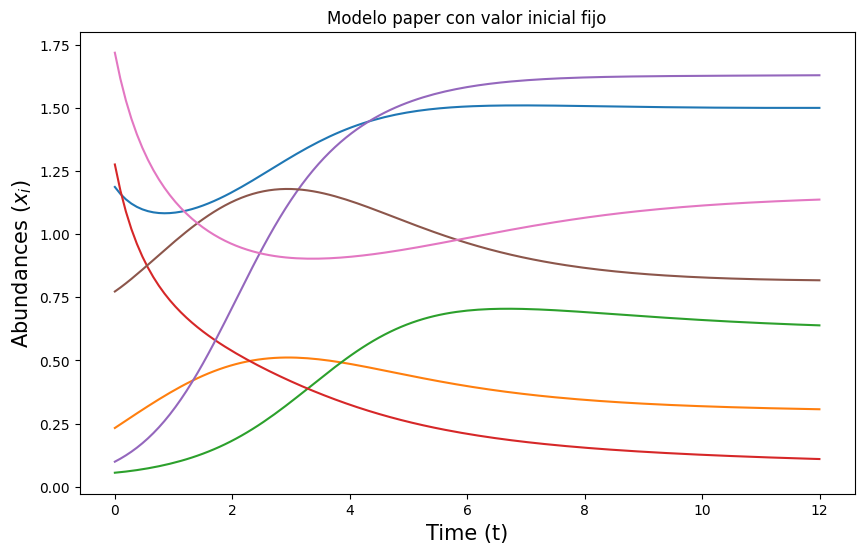

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# %%

# Definition of the parameters of the LV-model:
N_SIZE = 7  # dimension of the population
RHO = 0  # correlation
ALPHA = 1.4  # interaction strength

A = elliptic_normal_matrix(N_SIZE, RHO) / \
    (np.sqrt(N_SIZE)*ALPHA)  # Matrix of interactions

# %%

# Parameter of the dynamics:
NBR_IT = 129  # Number of iteractions
TAU = 0.093  # Time step
x_init = np.random.random(N_SIZE)*2  # Initial condition
#x_init = np.ones(N_SIZE) * 1/2


# Compute the dynamics:
sol_dyn = dynamics_LV(A, x_init, nbr_it=NBR_IT, tau=TAU)  # y-axis
x_axis = np.linspace(0, NBR_IT*TAU, NBR_IT)  # x-axis

# Display the dynamics:
fig = plt.figure(1, figsize=(10, 6))
for i in range(sol_dyn.shape[0]):
    lab = '$N_{'+str(i+1)+'}$'
    plt.plot(x_axis, sol_dyn[i, :], label=lab)
plt.xlabel("Time (t)", fontsize=15)
plt.ylabel("Abundances ($x_i$)", fontsize=15)
plt.title('Modelo paper con valor inicial fijo')
plt.show()